## Table of Contents
## 1)  [First Question](#q1)
###    - [First Evaluation](#e1)
## 2) [Second Question](#q2)
###    - [Second Evaluation](#e2)

## Problem 3
* Dataset used will be from Course Project, but will perform different question not used in course project
* the first question will be a classical question to see whether I can predict Odor from the predictor variables
* the second question will deal with unsupervised learning and see whether I can learn hidden patterns from the
mushroom categories themselves
* Evaluation and reference to which datacamp course was used will be documented in the notebook after each trial run

In [1]:
# Import packages

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from IPython.core.display import display
import seaborn as sns

from scipy import stats
from sklearn.preprocessing import LabelEncoder, OneHotEncoder, OrdinalEncoder
from sklearn.pipeline import Pipeline
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split, GridSearchCV, RandomizedSearchCV
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LinearRegression, LogisticRegression
from sklearn.svm import SVR
from sklearn.preprocessing import StandardScaler, OrdinalEncoder, OneHotEncoder
from sklearn.cluster import KMeans, AgglomerativeClustering
from sklearn.compose import ColumnTransformer
from sklearn.metrics import confusion_matrix, plot_confusion_matrix, accuracy_score, classification_report
import plotly.express as px
from kmodes.kmodes import KModes

from scipy.cluster.hierarchy import linkage, dendrogram, cut_tree
import joblib

from sklearn import set_config
sns.set_palette('Set2')
set_config(display='diagram')

from yellowbrick.cluster import KElbowVisualizer


## First Question <a class="anchor" id="q1"></a>
### Predict the odor of mushroom from its predictor variables (different from course project which predicts edibility)
### Classification methods will be used
### Dataset: Mushroom edibility, source: from https://archive.ics.uci.edu/ml/datasets/mushroom
* imported dataset will be already cleaned from course project

In [2]:
# import dataset
mushroom = pd.read_csv('data/mushroom_imputed_2_adj.csv')
mushroom.head()

,Class,Cap-Shape,Cap-Surface,Cap-Color,Bruises,Odor,Gill-Attachment,Gill-Spacing,Gill-Size,Gill-Color,...,Stalk-Surface-Above-Ring,Stalk-Surface-Below-Ring,Stalk-Color-Above-Ring,Stalk-Color-Below-Ring,Veil-Color,Ring-Number,Ring-Type,Spore-Print-Color,Population,Habitat
0,poisonous,convex,smooth,brown,bruises,pungent,free,close,narrow,black,...,smooth,smooth,white,white,white,one,pendant,black,scattered,urban
1,edible,convex,smooth,yellow,bruises,almond,free,close,broad,black,...,smooth,smooth,white,white,white,one,pendant,brown,numerous,grasses
2,edible,bell,smooth,white,bruises,anise,free,close,broad,brown,...,smooth,smooth,white,white,white,one,pendant,brown,numerous,meadows
3,poisonous,convex,scaly,white,bruises,pungent,free,close,narrow,brown,...,smooth,smooth,white,white,white,one,pendant,black,scattered,urban
4,edible,convex,smooth,gray,no,none,free,crowded,broad,black,...,smooth,smooth,white,white,white,one,evanescent,brown,abundant,grasses


In [54]:
X = mushroom.drop('Odor', axis=1)
y = mushroom[['Odor']]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=.25, random_state=42)
X_train.shape

(6084, 21)

In [55]:
# Preprocessing the training data

ordinal_X = OrdinalEncoder()
X_train = ordinal_X.fit_transform(X_train)

ordinal_y = OrdinalEncoder()
y_train = ordinal_y.fit_transform((y_train))

display('X train', X_train, 'y train', y_train)


'X train'

array([[1., 4., 2., ..., 7., 4., 1.],
       [1., 4., 3., ..., 7., 4., 6.],
       [0., 2., 2., ..., 0., 4., 6.],
       ...,
       [0., 3., 2., ..., 1., 5., 3.],
       [0., 0., 3., ..., 7., 3., 0.],
       [0., 4., 0., ..., 7., 2., 0.]])

'y train'

array([[3.],
       [3.],
       [6.],
       ...,
       [1.],
       [6.],
       [6.]])

In [56]:
# preprocess the test data

X_test = ordinal_X.transform(X_test)

y_test = ordinal_y.transform(y_test)

display('X test', X_test, 'y test', y_test)

'X test'

array([[0., 3., 0., ..., 1., 4., 6.],
       [0., 2., 0., ..., 1., 4., 6.],
       [0., 2., 3., ..., 1., 4., 1.],
       ...,
       [1., 3., 2., ..., 7., 1., 6.],
       [0., 0., 3., ..., 1., 1., 1.],
       [0., 2., 2., ..., 0., 5., 6.]])

'y test'

array([[6.],
       [1.],
       [6.],
       ...,
       [5.],
       [6.],
       [6.]])

In [57]:
# make y_train and y_test one dimensional for random forest classifier

y_train = np.concatenate(y_train).ravel()
y_test = np.concatenate(y_test).ravel()
y_train, y_test

(array([3., 3., 6., ..., 1., 6., 6.]), array([6., 1., 6., ..., 5., 6., 6.]))

In [7]:
# run data on Decision Tree Classifier

rf_grid = GridSearchCV(RandomForestClassifier(random_state=42), {}, cv=5)
rf_grid.fit(X_train, y_train)

GridSearchCV(cv=5, estimator=RandomForestClassifier(random_state=42),
             param_grid={})

In [8]:
print('train score', rf_grid.best_score_)
print('test score', rf_grid.score(X_test, y_test))
print('std dev', rf_grid.cv_results_['std_test_score'][rf_grid.best_index_])

train score 0.7281393255632919
test score 0.6962524654832347
std dev 0.006159606539859663


This means we are overfitting our dataset and need to perform some hyperparameter tuning to reduce this overfit


In [9]:
# higher estimators reduces variance,
# higher min samples will also reduce overfit
# smaller number of max featuers will reduce overfit

rf_param_grid = {
    'n_estimators':[250, 500],
     'max_features':['log2', 'sqrt'],
     'min_samples_leaf':[175, 200, 500, 1000]
}

In [10]:
# rf_grid2 = GridSearchCV(RandomForestClassifier(random_state=42), rf_param_grid, cv=5)
# rf_grid2.fit(X_train, y_train)
rf_grid2 = RandomizedSearchCV(RandomForestClassifier(random_state=42), rf_param_grid, cv=5, random_state=42)
rf_grid2.fit(X_train, y_train)

RandomizedSearchCV(cv=5, estimator=RandomForestClassifier(random_state=42),
                   param_distributions={'max_features': ['log2', 'sqrt'],
                                        'min_samples_leaf': [175, 200, 500,
                                                             1000],
                                        'n_estimators': [250, 500]},
                   random_state=42)

In [11]:
print('train score', rf_grid2.best_score_)
print('test score', rf_grid2.score(X_test, y_test))
print('std dev', rf_grid2.cv_results_['std_test_score'][rf_grid2.best_index_])

train score 0.7596985414954807
test score 0.7731755424063116
std dev 0.004702713080633196


In [12]:
rf_grid2.best_params_

{'n_estimators': 250, 'min_samples_leaf': 175, 'max_features': 'log2'}

In [59]:
print('Confusion Matrix \n',confusion_matrix(rf_grid2.predict(X_test),y_test), '\n')
print('Accuracy Score \n', rf_grid2.score(X_test, y_test), '\n')
print('Classification Report \n',classification_report(rf_grid2.predict(X_test),y_test))


Confusion Matrix 
 [[ 58  67   0   0   0   0   0   0   0]
 [ 17  10   0   0   0   0   0   0   0]
 [  0   0  50   0   0   0   0   0   0]
 [  0   0   0   0   0   0   0   0   0]
 [  0   0   0 149 519  11   9   0 134]
 [  0   0   0   0   0   0   0   0   0]
 [ 27  33   0   0   0   0 852   0   0]
 [  0   0   0   0   0   0   0  76   0]
 [  0   0   0   4   9   0   0   0   3]] 

Accuracy Score 
 0.7731755424063116 

Classification Report 
               precision    recall  f1-score   support

         0.0       0.57      0.46      0.51       125
         1.0       0.09      0.37      0.15        27
         2.0       1.00      1.00      1.00        50
         3.0       0.00      0.00      0.00         0
         4.0       0.98      0.63      0.77       822
         5.0       0.00      0.00      0.00         0
         6.0       0.99      0.93      0.96       912
         7.0       1.00      1.00      1.00        76
         8.0       0.02      0.19      0.04        16

    accuracy           

/home/wkc/.local/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/wkc/.local/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/wkc/.local/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [77]:
# to aid in deciphering confusion matrix
for num, odor in enumerate(ordinal_y.categories_[:][0].tolist()):
    print(num, odor)

0 almond
1 anise
2 creosote
3 fishy
4 foul
5 musty
6 none
7 pungent
8 spicy


In [86]:
pd.Series(rf_grid2.best_estimator_.feature_importances_, index=X.columns).sort_values(ascending=False)

Class                       0.240646
Spore-Print-Color           0.122426
Gill-Size                   0.081778
Ring-Type                   0.063429
Stalk-Shape                 0.055286
Cap-Color                   0.052545
Stalk-Color-Above-Ring      0.047043
Stalk-Color-Below-Ring      0.044781
Stalk-Surface-Below-Ring    0.044467
Stalk-Root                  0.044097
Population                  0.035879
Stalk-Surface-Above-Ring    0.035127
Bruises                     0.030531
Gill-Spacing                0.028306
Habitat                     0.024324
Gill-Color                  0.020235
Ring-Number                 0.015766
Cap-Surface                 0.009843
Cap-Shape                   0.003490
Veil-Color                  0.000000
Gill-Attachment             0.000000
dtype: float64

## Evaluation <a class="anchor" id="e1"></a>
With hyperaparemter tuning we were better able to predict odors of a mushroom from its features. The tuned forest
yielded a much better accuracy fit with a 1% difference and better performance than the untuned random forest classifier.
Also it did not overfit like the untune forest classifier.

Also from the confusion matrix it appears that our model does a poot job in precision of anise and spicy odors
It also appears that fishy and musty odors are not included in our dataset.
Our model does a very accurate job in precision and recall for fishy, none, and pungent smells. It odes a moderate job
for almond smells.

Overally the accuracy of our model yeilds a score of .77 which is strong score.

Last the features that were regarded as most important in predicting our model were class, which was edibility of mushroom,
spore-print color, Gill-size, Ring-Type, and Stalk-shape

From datacamp, the methods used such as Random Forest Classifer as well as hypertuning, came from the
'Machine Learning with Tree-Based Models in Python' course.

## Second Question <a class="anchor" id="q2"></a>
### Use clustering to learn hidden patterns from the mushroom dataset
### Using same dataset as First Question

In [22]:
mushroom
X = mushroom.copy()
X

,Class,Cap-Shape,Cap-Surface,Cap-Color,Bruises,Odor,Gill-Attachment,Gill-Spacing,Gill-Size,Gill-Color,...,Stalk-Surface-Above-Ring,Stalk-Surface-Below-Ring,Stalk-Color-Above-Ring,Stalk-Color-Below-Ring,Veil-Color,Ring-Number,Ring-Type,Spore-Print-Color,Population,Habitat
0,poisonous,convex,smooth,brown,bruises,pungent,free,close,narrow,black,...,smooth,smooth,white,white,white,one,pendant,black,scattered,urban
1,edible,convex,smooth,yellow,bruises,almond,free,close,broad,black,...,smooth,smooth,white,white,white,one,pendant,brown,numerous,grasses
2,edible,bell,smooth,white,bruises,anise,free,close,broad,brown,...,smooth,smooth,white,white,white,one,pendant,brown,numerous,meadows
3,poisonous,convex,scaly,white,bruises,pungent,free,close,narrow,brown,...,smooth,smooth,white,white,white,one,pendant,black,scattered,urban
4,edible,convex,smooth,gray,no,none,free,crowded,broad,black,...,smooth,smooth,white,white,white,one,evanescent,brown,abundant,grasses
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8107,edible,convex,smooth,brown,no,none,attached,close,broad,yellow,...,smooth,smooth,orange,orange,brown,one,pendant,buff,several,leaves
8108,edible,flat,smooth,brown,no,none,attached,close,broad,brown,...,smooth,smooth,orange,orange,orange,one,pendant,buff,clustered,leaves
8109,poisonous,knobbed,scaly,brown,no,fishy,free,close,narrow,buff,...,smooth,silky,white,white,white,one,evanescent,white,several,leaves
8110,edible,convex,smooth,brown,no,none,attached,close,broad,yellow,...,smooth,smooth,orange,orange,orange,one,pendant,orange,clustered,leaves


In [23]:
ordinal_enc = OrdinalEncoder()
X = ordinal_enc.fit_transform(X)
X

array([[1., 2., 3., ..., 0., 3., 4.],
       [0., 2., 3., ..., 1., 2., 0.],
       [0., 0., 3., ..., 1., 2., 2.],
       ...,
       [1., 4., 2., ..., 7., 4., 1.],
       [0., 2., 3., ..., 5., 1., 1.],
       [0., 4., 3., ..., 7., 3., 0.]])

In [24]:
km = KModes(random_state=42)

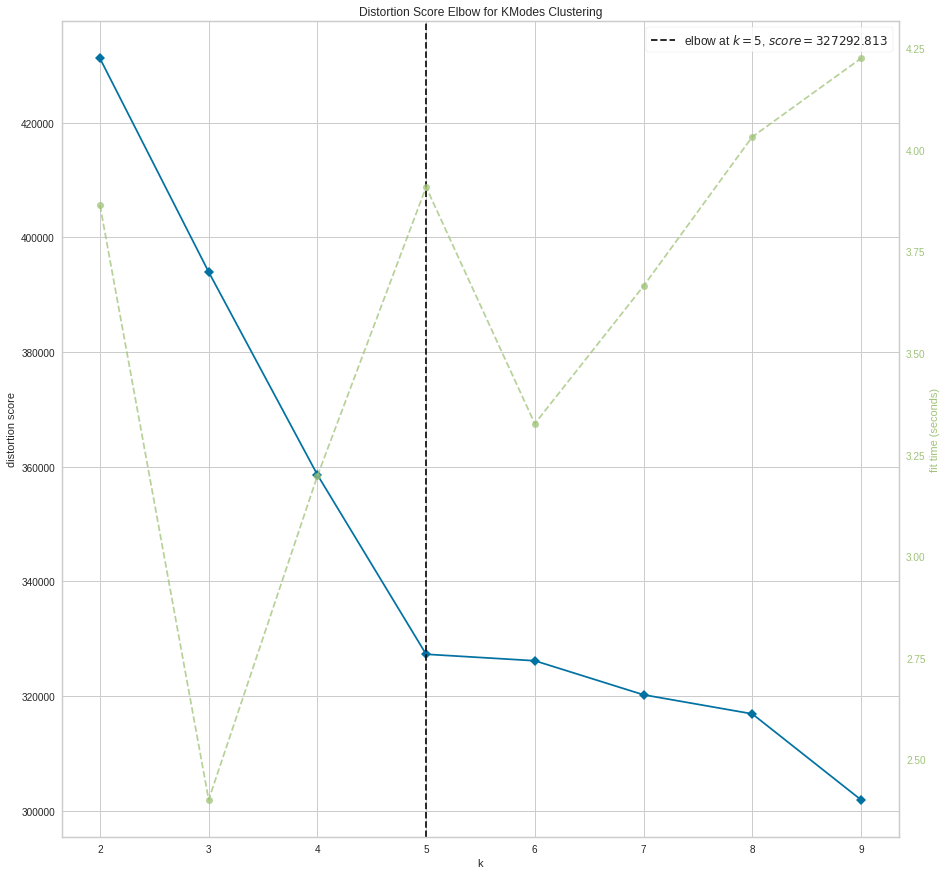

<AxesSubplot:title={'center':'Distortion Score Elbow for KModes Clustering'}, xlabel='k', ylabel='distortion score'>

In [25]:
plt.figure(figsize=(15,15))

# run KMode from k values 2 to 10
elbow_visualizer = KElbowVisualizer(km, k=(2,10))
elbow_visualizer.fit(X)
elbow_visualizer.show()

The elbow method from this graph says there should be 5 clusters


In [26]:
mushroom.columns

Index(['Class', 'Cap-Shape', 'Cap-Surface', 'Cap-Color', 'Bruises', 'Odor',
       'Gill-Attachment', 'Gill-Spacing', 'Gill-Size', 'Gill-Color',
       'Stalk-Shape', 'Stalk-Root', 'Stalk-Surface-Above-Ring',
       'Stalk-Surface-Below-Ring', 'Stalk-Color-Above-Ring',
       'Stalk-Color-Below-Ring', 'Veil-Color', 'Ring-Number', 'Ring-Type',
       'Spore-Print-Color', 'Population', 'Habitat'],
      dtype='object')

In [27]:
km5 = KModes(n_clusters=5, random_state=42)
km5.fit(X)

kmode_clusters = km5.labels_
kmode_centroids = km5.cluster_centroids_

In [42]:
mushroom_d = pd.DataFrame(X, columns=mushroom.columns)
mushroom_d.insert(0, 'Cluster_Id', kmode_clusters)
mushroom_d

,Cluster_Id,Class,Cap-Shape,Cap-Surface,Cap-Color,Bruises,Odor,Gill-Attachment,Gill-Spacing,Gill-Size,...,Stalk-Surface-Above-Ring,Stalk-Surface-Below-Ring,Stalk-Color-Above-Ring,Stalk-Color-Below-Ring,Veil-Color,Ring-Number,Ring-Type,Spore-Print-Color,Population,Habitat
0,0,1.0,2.0,3.0,0.0,0.0,7.0,1.0,0.0,1.0,...,3.0,3.0,7.0,7.0,2.0,1.0,4.0,0.0,3.0,4.0
1,0,0.0,2.0,3.0,9.0,0.0,0.0,1.0,0.0,0.0,...,3.0,3.0,7.0,7.0,2.0,1.0,4.0,1.0,2.0,0.0
2,0,0.0,0.0,3.0,8.0,0.0,1.0,1.0,0.0,0.0,...,3.0,3.0,7.0,7.0,2.0,1.0,4.0,1.0,2.0,2.0
3,0,1.0,2.0,2.0,8.0,0.0,7.0,1.0,0.0,1.0,...,3.0,3.0,7.0,7.0,2.0,1.0,4.0,0.0,3.0,4.0
4,4,0.0,2.0,3.0,3.0,1.0,6.0,1.0,1.0,0.0,...,3.0,3.0,7.0,7.0,2.0,1.0,0.0,1.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8107,0,0.0,2.0,3.0,0.0,1.0,6.0,0.0,0.0,0.0,...,3.0,3.0,4.0,4.0,0.0,1.0,4.0,2.0,4.0,1.0
8108,4,0.0,3.0,3.0,0.0,1.0,6.0,0.0,0.0,0.0,...,3.0,3.0,4.0,4.0,1.0,1.0,4.0,2.0,1.0,1.0
8109,2,1.0,4.0,2.0,0.0,1.0,3.0,1.0,0.0,1.0,...,3.0,2.0,7.0,7.0,2.0,1.0,0.0,7.0,4.0,1.0
8110,0,0.0,2.0,3.0,0.0,1.0,6.0,0.0,0.0,0.0,...,3.0,3.0,4.0,4.0,1.0,1.0,4.0,5.0,1.0,1.0


In [57]:
# we group by mode because our categoires are not ordinal by nature
mushroom_clusters = mushroom_d[mushroom_d.columns.tolist()].groupby('Cluster_Id').agg(lambda x:x.value_counts().index[0])
mushroom_clusters

,Class,Cap-Shape,Cap-Surface,Cap-Color,Bruises,Odor,Gill-Attachment,Gill-Spacing,Gill-Size,Gill-Color,...,Stalk-Surface-Above-Ring,Stalk-Surface-Below-Ring,Stalk-Color-Above-Ring,Stalk-Color-Below-Ring,Veil-Color,Ring-Number,Ring-Type,Spore-Print-Color,Population,Habitat
Cluster_Id,,,,,,,,,,,,,,,,,,,,,
0,0.0,2.0,2.0,0.0,0.0,6.0,1.0,0.0,0.0,10.0,...,3.0,3.0,7.0,7.0,2.0,1.0,4.0,1.0,4.0,6.0
1,1.0,2.0,2.0,9.0,1.0,4.0,1.0,0.0,0.0,4.0,...,2.0,2.0,5.0,0.0,2.0,1.0,2.0,3.0,4.0,6.0
2,1.0,3.0,2.0,0.0,1.0,8.0,1.0,0.0,1.0,2.0,...,2.0,3.0,7.0,5.0,2.0,1.0,0.0,7.0,4.0,6.0
3,0.0,2.0,3.0,8.0,1.0,6.0,1.0,1.0,0.0,10.0,...,3.0,3.0,7.0,7.0,2.0,2.0,4.0,7.0,3.0,0.0
4,0.0,3.0,3.0,8.0,1.0,6.0,1.0,1.0,0.0,1.0,...,3.0,3.0,7.0,7.0,2.0,1.0,0.0,0.0,3.0,0.0


In [58]:
mushroom_clusters.shape

(5, 22)

In [59]:
# Make a dataframe with labels instead of encoded values for interpretability
mushroom_clusters = pd.DataFrame(ordinal_enc.inverse_transform(mushroom_clusters), columns=mushroom_clusters.columns)
mushroom_clusters

,Class,Cap-Shape,Cap-Surface,Cap-Color,Bruises,Odor,Gill-Attachment,Gill-Spacing,Gill-Size,Gill-Color,...,Stalk-Surface-Above-Ring,Stalk-Surface-Below-Ring,Stalk-Color-Above-Ring,Stalk-Color-Below-Ring,Veil-Color,Ring-Number,Ring-Type,Spore-Print-Color,Population,Habitat
0,edible,convex,scaly,brown,bruises,none,free,close,broad,white,...,smooth,smooth,white,white,white,one,pendant,brown,several,woods
1,poisonous,convex,scaly,yellow,no,foul,free,close,broad,gray,...,silky,silky,pink,brown,white,one,large,chocolate,several,woods
2,poisonous,flat,scaly,brown,no,spicy,free,close,narrow,buff,...,silky,smooth,white,pink,white,one,evanescent,white,several,woods
3,edible,convex,smooth,white,no,none,free,crowded,broad,white,...,smooth,smooth,white,white,white,two,pendant,white,scattered,grasses
4,edible,flat,smooth,white,no,none,free,crowded,broad,brown,...,smooth,smooth,white,white,white,one,evanescent,black,scattered,grasses


In [69]:
mushroom_clusters.T

,0,1,2,3,4
Class,edible,poisonous,poisonous,edible,edible
Cap-Shape,convex,convex,flat,convex,flat
Cap-Surface,scaly,scaly,scaly,smooth,smooth
Cap-Color,brown,yellow,brown,white,white
Bruises,bruises,no,no,no,no
Odor,none,foul,spicy,none,none
Gill-Attachment,free,free,free,free,free
Gill-Spacing,close,close,close,crowded,crowded
Gill-Size,broad,broad,narrow,broad,broad
Gill-Color,white,gray,buff,white,brown


### Evaluation <a class="anchor" id="e2"></a>
Because our categories are not ordinal of nature we cannot necessarily use a mean for our average because it would make
least sense in terms of interpretation. Instead mode for our average was used as frequency features makes most sense for
our problem and would lead to more interpretability.

From our results, it appears that 5 clusters can be generated from the mushroom dataset.
From the 5 clusters, some prominent features noted
* Cluster 0: edible, no odor, white gill-color, and stalk-surface-above-ring is smooth
* Cluster 1: poisonous, foul odor, gray gill-color, and stalk-surface-above-ring is silky
* Cluster 2: poisonous, spicy odor, buff gill color, and stalk-surface-above-ring is silky
* Cluster 3: Edible, no odor, white gill color, and stalk-surface-above-ring is smooth
* Cluster 4: Edible, no odor, brown gill color, and stalk-surface-above-ring is smooth

This pattern in analysis leads to belief that edible mushrooms will often have no smell, and have a stalk-surface-above-ring
this is smooth.
Other notable patterns from looking at the clusters are that mushrooms in wood habitats have serveral population, wheras
grass habitat mushrooms have scattered populations, and crowded gill-spacing rather than close.

The methods for answering this question were taken from the Cluster Analysis datacamp course, particularly the
elbow method used to determine the optimum number of clusters to choose from. Also the explanation of clustering
and using visuals for interpretation from the Cluster Analysis in Python course were used as well. Unfortunately
because datacamp only explains and uses kmeans in the course, learning to kmode was taken from a separate online
source, the Pypi.org libraries.